In [295]:
# MTF073 Computational Fluid Dynamics
# Task 2: convection-diffusion
# Håkan Nilsson, 2023
# Department of Mechanics and Maritime Sciences
# Division of Fluid Dynamics
# Note that this is not efficient code. It is for educational purposes!

# The code assumes that the folder with data is in the same path as this file

# Clear all variables when running entire code:
from IPython import get_ipython
get_ipython().run_line_magic('reset', '-sf')
# Packages needed
import numpy as np
import matplotlib.pyplot as plt
# Close all plots when running entire code:
plt.close('all')
# Set default font size in plots:
plt.rcParams.update({'font.size': 12})
import sys # For sys.exit()
import os # For saving plots
#===================== Inputs =====================

# Geometric and mesh inputs (mesh is read from file)
grid_type = 'coarse' # Either 'coarse' or 'fine'
caseID    =   20       # Your case number to solve

# Solver inputs
nIter  = 6000    # set maximum number of iterations
resTol = 0.0001 # set convergence criteria for residuals
solver = 'TDMA'  # Either Gauss-Seidel or TDMA

# Physical properties
rho    =   1    # Density
k      =   1    # Thermal conductivity 
Cp     =   200  # Specific heat
gamma  =   k/Cp # Calculated diffusion coefficient
q_in = 50 /Cp   #W/m^2
#====================== Code ======================

# Read grid and velocity data:
match caseID:
    case 1 | 2 | 3 | 4 | 5:
        grid_number = 1
    case 6 | 7 | 8 | 9 | 10:
        grid_number = 2
    case 11 | 12 | 13 | 14 | 15:
        grid_number = 3
    case 16 | 17 | 18 | 19 | 20:
        grid_number = 4
    case 21 | 22 | 23 | 24 | 25:
        grid_number = 5
    case _:
        sys.exit("No mesh for chosen caseID!")
path = 'data/grid%d/%s_grid' % (grid_number,grid_type)
pointXvector = np.genfromtxt('%s/xc.dat' % (path)) # x node coordinates
pointYvector = np.genfromtxt('%s/yc.dat' % (path)) # y node coordinates
u_datavector = np.genfromtxt('%s/u.dat' % (path))  # u velocity at the nodes
v_datavector = np.genfromtxt('%s/v.dat' % (path))  # v veloctiy at the nodes

# Preparation of "nan", to fill empty slots in consistently numbered arrays.
# This makes it easier to check in Variable Explorer that values that should
# never be set are never set (or used). Plots simply omit nan values.
nan = float("nan")

# Allocate arrays (nan used to make clear where values need to be set)
# Note that some arrays could actually be 1D since they only have a variation
# in one direction, but they are kept 2D so the indexing is similar for all.
mI     = len(pointXvector);          # Number of mesh points X direction
mJ     = len(pointYvector);          # Number of mesh points X direction
nI     = mI + 1;                     # Number of nodes in X direction, incl. boundaries
nJ     = mJ + 1;                     # Number of nodes in Y direction, incl. boundaries
pointX = np.zeros((mI,mJ))*nan       # X coords of the mesh points, in points
pointY = np.zeros((mI,mJ))*nan       # Y coords of the mesh points, in points
nodeX  = np.zeros((nI,nJ))*nan       # X coords of the nodes, in nodes
nodeY  = np.zeros((nI,nJ))*nan       # Y coords of the nodes, in nodes
dx_PE  = np.zeros((nI,nJ))*nan       # X distance to east node, in nodes
dx_WP  = np.zeros((nI,nJ))*nan       # X distance to west node, in nodes
dy_PN  = np.zeros((nI,nJ))*nan       # Y distance to north node, in nodes
dy_SP  = np.zeros((nI,nJ))*nan       # Y distance to south node, in nodes
dx_we  = np.zeros((nI,nJ))*nan       # X size of the control volume, in nodes
dy_sn  = np.zeros((nI,nJ))*nan       # Y size of the control volume, in nodes
aE     = np.zeros((nI,nJ))*nan       # Array for east coefficient, in nodes
aW     = np.zeros((nI,nJ))*nan       # Array for wect coefficient, in nodes
aN     = np.zeros((nI,nJ))*nan       # Array for north coefficient, in nodes
aS     = np.zeros((nI,nJ))*nan       # Array for south coefficient, in nodes
aP     = np.zeros((nI,nJ))*nan       # Array for central coefficient, in nodes
Su     = np.zeros((nI,nJ))           # Array for source term for temperature, in nodes
Sp     = np.zeros((nI,nJ))           # Array for source term for temperature, in nodes
T      = np.zeros((nI,nJ))*nan       # Array for temperature, in nodes
De     = np.zeros((nI,nJ))*nan       # Diffusive coefficient for east face, in nodes
Dw     = np.zeros((nI,nJ))*nan       # Diffusive coefficient for west face, in nodes
Dn     = np.zeros((nI,nJ))*nan       # Diffusive coefficient for north face, in nodes
Ds     = np.zeros((nI,nJ))*nan       # Diffusive coefficient for south face, in nodes
Fe     = np.zeros((nI,nJ))*nan       # Convective coefficients for east face, in nodes
Fw     = np.zeros((nI,nJ))*nan       # Convective coefficients for west face, in nodes
Fn     = np.zeros((nI,nJ))*nan       # Convective coefficients for north face, in nodes
Fs     = np.zeros((nI,nJ))*nan       # Convective coefficients for south face, in nodes
P      = np.zeros((nI,nJ))           # Array for TDMA, in nodes
Q      = np.zeros((nI,nJ))           # Array for TDMA, in nodes
u      = u_datavector.reshape(nI,nJ) # Values of x-velocity, in nodes
v      = v_datavector.reshape(nI,nJ) # Values of y-velocity, in nodes
res    = []                          # Array for appending residual each iteration
# Set wall velocities to exactly zero:
u[u == 1e-10] = 0
v[v == 1e-10] = 0

# Set point coordinates:
for i in range(0, mI):
    for j in range(0, mJ):
        pointX[i,j] = pointXvector[i]
        pointY[i,j] = pointYvector[j]

# Calculate length and height:
L = pointX[mI-1,0] - pointX[0,0]
H = pointY[0,mJ-1] - pointY[0,0]

# Calculate node coordinates (same for equidistant and non-equidistant):
# Internal nodes:
for i in range(0, nI):
    for j in range(0, nJ):
        if i > 0 and i < nI-1:
            nodeX[i,j] = 0.5*(pointX[i,0] + pointX[i-1,0])
        if j > 0 and j < nJ-1:
            nodeY[i,j] = 0.5*(pointY[0,j] + pointY[0,j-1])
# Boundary nodes:
nodeX[0,:]  = pointX[0,0]  # Note: corner points needed for contour plot
nodeY[:,0]  = pointY[0,0]  # Note: corner points needed for contour plot
nodeX[-1,:] = pointX[-1,0] # Note: corner points needed for contour plot
nodeY[:,-1] = pointY[0,-1] # Note: corner points needed for contour plot

# Calculate distances
# Keep 'nan' where values are not needed!
for i in range(1, nI-1):
    for j in range(1, nJ-1):
        dx_PE[i,j] = nodeX[i+1,j] - nodeX[i,j]
        dx_WP[i,j] = nodeX[i,j] - nodeX[i-1,j]
        dy_PN[i,j] = nodeY[i,j+1] - nodeY[i,j]
        dy_SP[i,j] = nodeY[i,j] - nodeY[i,j-1]
        dx_we[i,j] = pointX[i,j] - pointX[i-1,j]
        dy_sn[i,j] = pointY[i,j] - pointY[i,j-1]

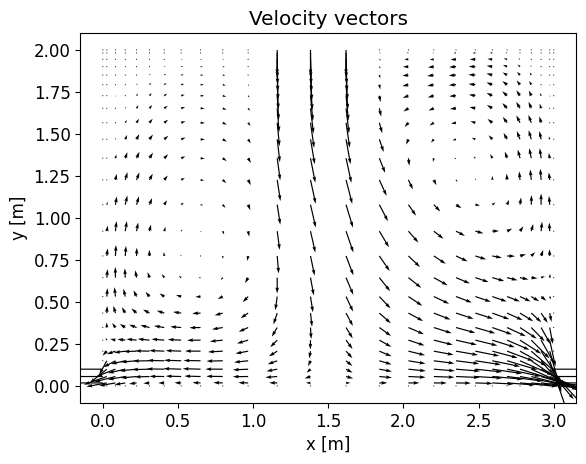

In [296]:
if True:
	plt.figure()
	plt.quiver(nodeX, nodeY, u, v)
	plt.title('Velocity vectors')
	plt.xlabel('x [m]')
	plt.ylabel('y [m]')


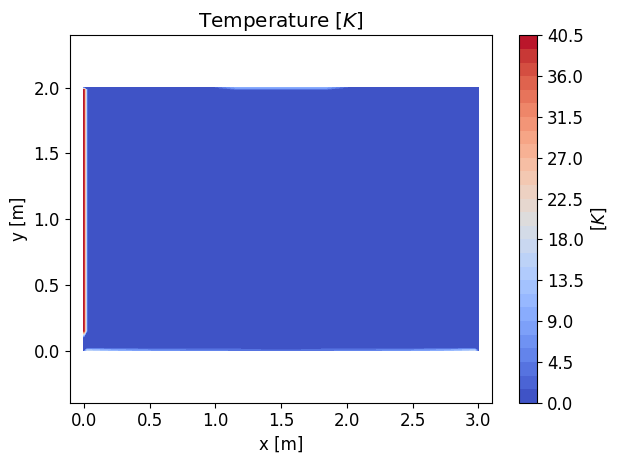

<Figure size 640x480 with 0 Axes>

In [297]:
# Initialize dependent variable array and Dirichlet boundary conditions
# Note that a value is needed in all nodes for contour plot
# Default:

T = np.ones_like(T)*0# for i in range(0,nI):
#     for j in range(0,nJ):
#         T[i,j] = 10

# Inlets (found by velocity into domain), walls (found by zero velocity):
for i in range(1,nI-1):
    j = nJ-1
    if v[i-1,j] != 0:
        T[i,j] = 10

    j = 0
    

for j in range(1,nJ-1):
    i = nI-1

    i = 0
    if u[i,j] == 0:
        T[i,j] = 40

# Set default/constant source terms:
#South wall
for i in range(1,nI-1):
    j = 0
    Su[i,j+1] = dx_we[i,j+1]* q_in
    T[i, j] = T[i,j+1] + (q_in/(gamma * dx_we[i,j+1])) * dy_SP[i,j+1]

# west wall
for j in range(1,nJ-1):
    i = 1
    if u[i-1,j] ==0:
        Su[i,j] = T[i-1,j]*dy_sn[i,j]/dx_WP[i,j] * gamma
        Sp[i,j] = -dy_sn[i,j]/dx_WP[i,j] * gamma

# north wall
for i in range(1,nI-1):
    j = -1
    if v[i,j] != 0:
        T[i,j] = 10


        


# Plot temperature contour
plt.figure()
plt.contourf(nodeX.T, nodeY.T, T.T)
tempmap=plt.contourf(nodeX.T,nodeY.T,T.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('$[K]$')
plt.title('Temperature $[K]$')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig('Figures/Case_'+str(caseID)+'_'+grid_type+'_temperatureDistribution.png')

In [298]:
# Calculate constant diffusive (D) and convective (F) coefficients
def interpolate(y1,y2,x1,x2):
    """" Linear interpolation
    Args:
        y1 : First point y value
        y2 : second point y value
        x1 : First cell width/height
        x2 : Second cell width/height

    Returns:
        y1 + (y2-y1)/(x2/2+x1/2) * x1/2
    """
    dx = x2/2 + x1/2
    return  y1 + (y2-y1)/dx * x1/2



for i in range(1,nI-1):
    for j in range(1,nJ-1):
        De[i,j] = gamma/dx_PE[i,j] * dy_sn[i,j]
        Dw[i,j] = gamma/dx_WP[i,j] * dy_sn[i,j]
        Dn[i,j] = gamma/dy_PN[i,j] * dx_we[i,j]
        Ds[i,j] = gamma/dy_SP[i,j] * dx_we[i,j]
        fxe = 0.5*dx_we[i,j] / dx_PE[i,j]
        fxw = 0.5*dx_we[i,j] / dx_WP[i,j]
        fyn = 0.5*dy_sn[i,j] / dy_PN[i,j]
        fys = 0.5*dy_sn[i,j] / dy_SP[i,j]
        
        fxe = interpolate(u[i,j],u[i+1,j],dx_we[i,j],dx_we[i+1,j])
        fxw = interpolate(u[i,j],u[i-1,j],dx_we[i,j],dx_we[i-1,j])
        fyn = interpolate(v[i,j],v[i,j+1],dy_sn[i,j],dy_sn[i,j+1])
        fys = interpolate(v[i,j],v[i,j-1],dy_sn[i,j],dy_sn[i,j-1])
        
        Fe[i,j] = rho * fxe * dy_sn[i,j]
        Fw[i,j] = rho * fxw * dy_sn[i,j]
        Fn[i,j] = rho * fyn * dx_we[i,j]
        Fs[i,j] = rho * fys * dx_we[i,j]

# boundary adjacent nodes, no need to intterpolate velocities
for j in range(1,nJ-1):
    i = nI-2
    Fe[i,j] = rho*u[i+1,j]* dy_sn[i,j]
    i = 1
    Fw[i,j] = rho*u[i-1,j] * dy_sn[i,j]
for i in range(1,nI-1):
    j = nJ-2
    Fn[i,j] = rho*v[i,j+1]* dy_sn[i,j]
    j = 1
    Fs[i,j] = rho*v[i,j-1]* dy_sn[i,j]

In [299]:
# Calculate constant Hybrid scheme coefficients (not taking into account boundary conditions)
for i in range(1,nI-1):
    for j in range(1,nJ-1):
        fxe = 0.5*dx_we[i,j] / dx_PE[i,j]
        fxw = 0.5*dx_we[i,j] / dx_WP[i,j]
        fyn = 0.5*dy_sn[i,j] / dy_PN[i,j]
        fys = 0.5*dy_sn[i,j] / dy_SP[i,j]
        
        aE[i,j] = max([-Fe[i,j],De[i,j]-fxe*Fe[i,j], 0])
        aW[i,j] = max([Fw[i,j],Dw[i,j]+fxw*Fw[i,j], 0])
        aN[i,j] = max([-Fn[i,j],Dn[i,j]-fyn*Fn[i,j], 0])
        aS[i,j] = max([Fs[i,j],Ds[i,j]+fys*Fs[i,j], 0])
        
# At outlets (found by velocity out of domain), set homogeneous Neumann
for j in range(1,nJ-1):
    # East
    i = nI-2
    if u[i-1,j] > 0:
        aE[i,j] = 0
    # west
    i = 1
    if u[i-1,j] < 0:
        aW[i,j] = 0
for i in range(1,nI-1):
    j = nJ-2
    # north
    if v[i,j-1] > 0:
        aN[i,j] = 0    
    # south
    j = 1
    if v[i,j-1] < 0:
        aS[i,j] = 0


In [300]:
# (Homogeneous) Neumann walls (found by zero velocity):
for j in range(1,nJ-1):
    # East wall:
    i = -2
    if u[i+1,j] == 0:
        aE[i,j] = 0
    # West wall: Dirichlet
    i = 1
    # aW[i,j] = 0

for i in range(1,nI-1):
    # North wall:
    j = -2
    if v[i,j+1] == 0:
        aN[i,j] = 0

    # South wall: neumann
    j = 1
    if v[i,j-1] == 0:
        aS[i,j] = 0
    

for i in range(1,nI-1):
    for j in range(1,nJ-1): 
        aP[i,j] = aW[i,j] + aE[i,j] + aN[i,j] + aS[i,j] - Sp[i,j]


In [301]:
# The following loop is for the linear solver.
in_ = []
out_ = []
point = (nI//2, nJ//2)
certain_T = []
from datetime import datetime
glob_imbal = []
start = datetime.now()
for iter in range(nIter): 
    # Solve for T using Gauss-Seidel
    if solver == 'Gauss-Seidel':
        for i in range(1, nI - 1):
            for j in range(1, nJ - 1):
                T[i, j] = ((aW[i, j] * T[i - 1, j] + aE[i, j] * T[i + 1, j] + aS[i, j] \
                        * T[i, j - 1] + aN[i, j] * T[i, j + 1] + Su[i,j] ) / aP[i, j])
    
    # Solve for T using TDMA
    if solver == 'TDMA':
        a = np.zeros([nI,nJ])
        b = np.zeros([nI,nJ])
        c = np.zeros([nI,nJ])
        d = np.zeros([nI,nJ])
        P = np.zeros([nI,nJ])
        Q = np.zeros([nI,nJ])
        #Solve horizontally
        if iter%2 ==0:
            for j in range(1,nJ-1):
                for i in range(1,nI-1):
                    a[i,j] = aP[i,j]  
                    b[i,j] = aE[i,j]  
                    c[i,j] = aW[i,j]  
                    d[i,j] = aN[i,j]*T[i,j+1] + aS[i,j] * T[i,j-1] + Su[i,j]
                #Construct P and Q terms
                i = 1
                P[i,j] = b[i,j] / a[i,j]
                Q[i,j] = (d[i,j] + c[i,j] * T[i-1,j])/a[i,j] 
                for i in range(2,nI-2):
                    P[i,j] = b[i,j] / (a[i,j] - c[i,j] * P[i-1,j])
                    Q[i,j] = (d[i,j] + c[i,j] * Q[i-1,j]) / (a[i,j] - c[i,j] * P[i-1,j])
                i=nI-2
                P[i,j] = 0
                Q[i,j] = (d[i,j] + c[i,j] * Q[i-1,j] + b[i,j] * T[i+1,j]) / (a[i,j] - c[i,j] * P[i-1,j])

                for i in reversed(range(1, nI-1)):
                    T[i,j] = P[i,j] * T[i+1,j] + Q[i,j]

        else: # Solve vertically
            for i in range(1,nI-1):
                for j in range(1,nJ-1):
                    a[i,j] = aP[i,j]  
                    b[i,j] = aN[i,j]  
                    c[i,j] = aS[i,j]  
                    d[i,j] = aE[i,j]*T[i+1,j] + aW[i,j] * T[i-1,j] + Su[i,j]
                #Construct P and Q terms
                j = 1
                P[i,j] = b[i,j] / a[i,j]
                Q[i,j] = (d[i,j] + c[i,j] * T[i,j-1])/a[i,j] 
                for j in range(2,nJ-2):
                    P[i,j] = b[i,j] / (a[i,j] - c[i,j] * P[i,j-1])
                    Q[i,j] = (d[i,j] + c[i,j] * Q[i,j-1]) / (a[i,j] - c[i,j] * P[i,j-1])
                j=nJ-2
                P[i,j] = 0
                Q[i,j] = (d[i,j] + c[i,j] * Q[i,j-1] + b[i,j] * T[i,j+1]) / (a[i,j] - c[i,j] * P[i,j-1])

                for j in reversed(range(1, nJ-1)):
                    T[i,j] = P[i,j] * T[i,j+1] + Q[i,j]
        

    # Copy T to walls where (non-)homogeneous Neumann is applied:
    # Note that specified heat flux is positive INTO computational domain!
    for j in range(1,nJ-1):
        # East wall:
        i = -1
        T[i, j] = T[i-1, j]
        # West wall:
        i = 0
        
    
    for i in range(1,nI-1):
        # North wall:
        j = -1
        if v[i,j] == 0:
            T[i,j] = T[i,j-1]
        
        # South wall:
        j = 0
        if v[i,j] == 0:
            T[i, j] = T[i,j+1] + (q_in/(gamma * dx_we[i,j+1])) * dy_SP[i,j+1]
    
    # Copy T to outlets (where homogeneous Neumann should always be applied):
    for j in range(1,nJ-1):
        # East wall:
        i = -1
        if u[i,j] > 0:
            T[i, j] = T[i-1, j]
        # West wall:
        i = 0
        if u[i,j] < 0:
            T[i, j] = T[i+1, j]
    
    for i in range(1,nI-1):
        # North wall:
        j = -1
        if v[i,j] > 0:
            T[i, j] = T[i, j-1]
        
        # South wall:
        j = 0
        if v[i,j] < 0:
            T[i, j] = T[i, j+1]
    
    # Set cornerpoint values to average of neighbouring boundary points
    T[0,0]   = np.mean([T[1,0],T[1,1],T[0,1]])
    T[-1,0]  = np.mean([T[-2,0],T[-2,1],T[-1,1]])
    T[0,-1]  = np.mean([T[1,-2],T[1,-1],T[0,-2]])
    T[-1,-1] = np.mean([T[-1,-2],T[-2,-1],T[-2,-2]])

    # Compute and print residuals (taking into account normalization):
    # Non-normalized residual:
    r0 = 0
    for i in range(1, nI-1):
        for j in range(1, nJ-1):
            r0 += abs(aP[i,j]*T[i,j] - (aW[i,j]*T[i-1,j] + aE[i,j]*T[i+1,j] + aN[i,j]*T[i,j+1] + aS[i,j]*T[i,j-1] + Su[i,j]))

    # Global convective and diffusive heat rates (divided by cp), for normalization:
    Fin = 0
    Fout = 0
    Din = 0
    Dout = 0    
    # Get the temperature gradient in cells
    dT_dx = np.zeros((nI, nJ))
    dT_dy = np.zeros((nI, nJ))
    # for i in range(1,nI-1):
        # for j in range(1,nJ-1):
        #     dT_dx[i, j] = (T[i+1, j] - T[i-1, j]) / (dx_WP[i, j] + dx_PE[i,j])
        #     dT_dy[i, j] = (T[i, j+1] - T[i, j-1]) / (dy_SP[i, j]+ dy_PN[i,j])

    dT_dx, dT_dy = np.gradient(T,nodeX[:,0],nodeY[0,:])
    inlet = 0
    outlet = 0
    
    # Add positive source terms to F and negative to F_out
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            if Sp[i,j]*T[i,j] > 0:
                inlet+= abs(Sp[i,j]*T[i,j])
            else:
                outlet += abs(Sp[i,j]*T[i,j])/Cp
            if Su[i,j] > 0:
                inlet += abs(Su[i,j])
            else:
                outlet += abs(Su[i,j])

    # south and north
    for i in range(1,nI-1):
        # j = 1
        # inlet += abs(gamma * dx_we[i, j] * dT_dy[i,j-1])
        
        j = -2
        inlet += abs(rho*v[i,j+1]*dx_we[i,j]*T[i,j+1]) 
        
    # west and east
    for j in range(1,nJ-1):
        i = 1
        # if u[i-1,j] == 0:
        #     inlet += abs(gamma * dy_sn[i, j] * dT_dx[i-1,j])

        outlet += abs(rho*u[i-1,j]*dy_sn[i,j]*T[i-1,j]) 
        

        i = -2
        outlet += abs(rho*u[i+1,j]*dy_sn[i,j]*T[i+1,j]) 
        
    
    F = inlet
    r = r0/F
    if iter % 50 == 0:
        print('iteration: %5d, res = %.5e' % (iter, r))
            
    in_.append(inlet*Cp)
    out_.append(outlet*Cp)
    # Compute residuals (taking into account normalization)
    # Append residual at present iteration to list of all residuals, for plotting:
    res.append(r)    
    certain_T.append(T[point])
    # Global heat rate imbalance

    glob_imbal.append(abs((inlet-outlet)/inlet))
    # Stop iterations if converged:
    if r < resTol:
        end = datetime.now()
        print('iteration: %5d, res = %.5e' % (iter, r))
        break

#================ Post-processing section ================
print('Global heat rate imbalance: %.2g%%' %(100 * glob_imbal[-1]))
print(solver +':  ' ,(end-start).total_seconds())

iteration:     0, res = 5.63756e-01
iteration:    50, res = 3.36839e-04
iteration:    61, res = 9.80945e-05
Global heat rate imbalance: 57%
TDMA:   0.303561


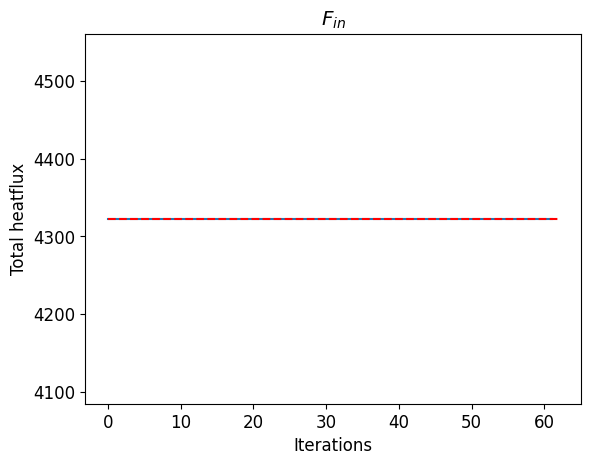

In [302]:
plt.plot(in_)
plt.hlines(in_[-1],0,len(in_), linestyles='dashed', colors='r')
plt.title('$F_{in}$')
plt.xlabel('Iterations')
plt.ylabel('Total heatflux')
plt.savefig('F_in.png')


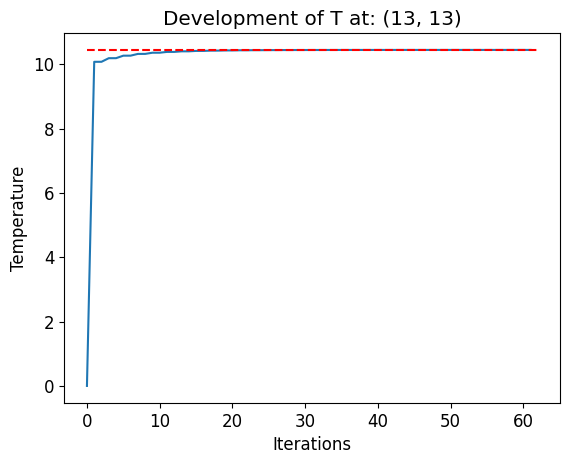

In [303]:
plt.plot(certain_T)
plt.title(f'Development of T at: {point}')
plt.hlines(certain_T[-1], 0, len(certain_T), colors='r', linestyles='dashed')
plt.xlabel('Iterations')
plt.ylabel('Temperature')
plt.savefig('T_development.png')

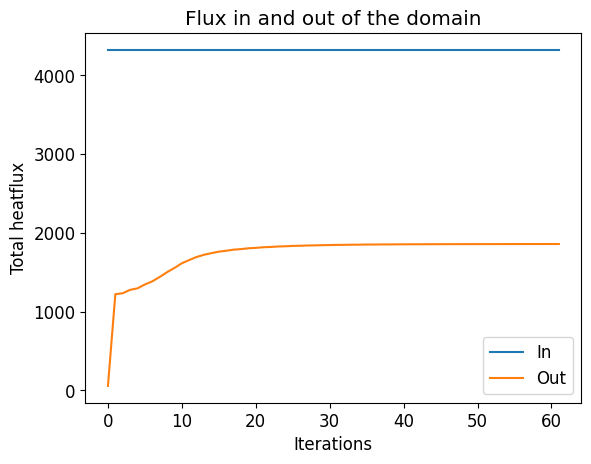

In [304]:
plt.plot(in_, label = 'In')
plt.plot(out_, label = 'Out')
plt.title('Flux in and out of the domain')
plt.xlabel('Iterations')
plt.ylabel('Total heatflux')
plt.legend()
plt.savefig('fluxes.png')

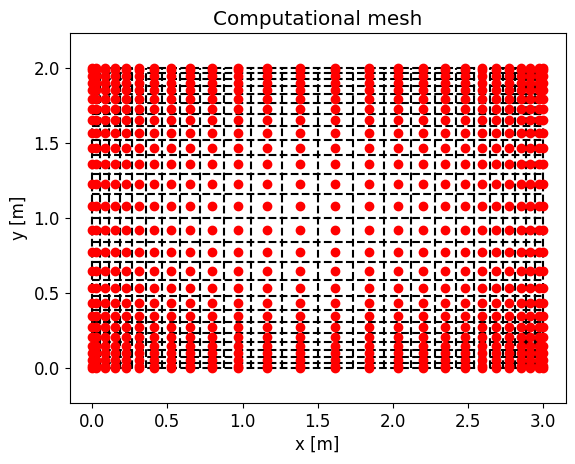

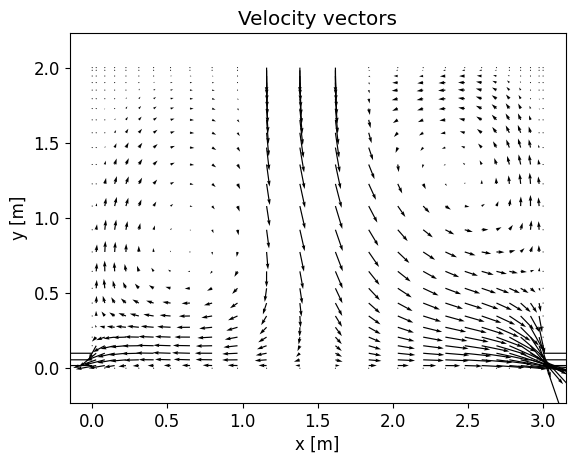

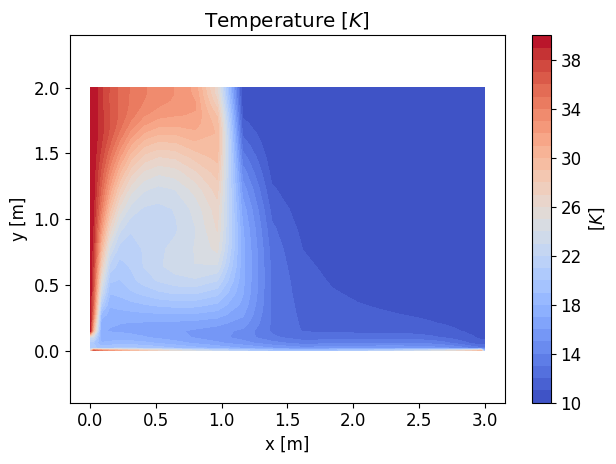

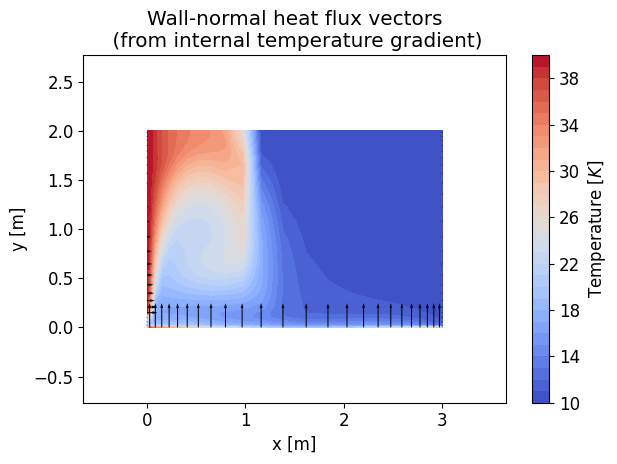

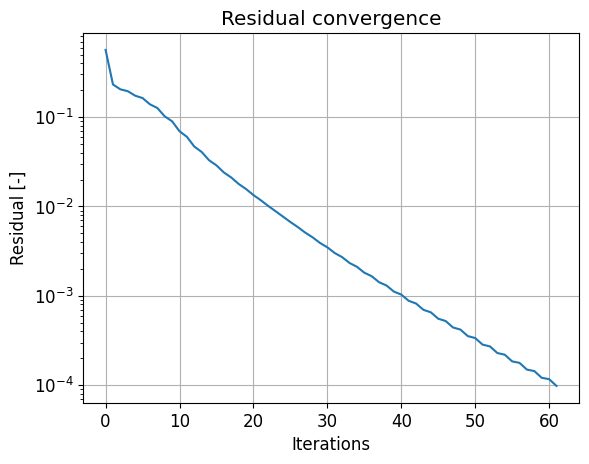

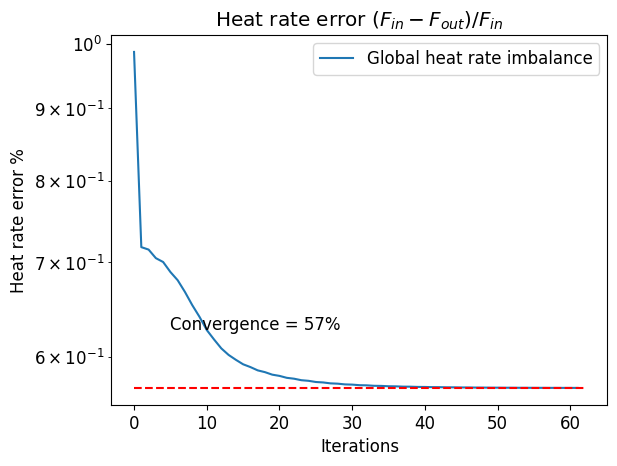

In [305]:

#================ Plotting section ================
# (only examples, more plots might be needed)

if not os.path.isdir('Figures/'+grid_type):
    os.makedirs('Figures/'+grid_type)

if not os.path.isdir('Figures/'+grid_type+'/'+solver):
    os.makedirs('Figures/'+grid_type+'/'+solver)

# Plot mesh
plt.figure()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Computational mesh')
plt.axis('equal')
plt.vlines(pointX[:,0],pointY[0,0],pointY[0,-1],colors = 'k',linestyles = 'dashed')
plt.hlines(pointY[0,:],pointX[0,0],pointX[-1,0],colors = 'k',linestyles = 'dashed')
plt.plot(nodeX, nodeY, 'ro')

plt.savefig('Figures/'+grid_type+'/'+solver+'/_Case_'+str(caseID)+'_mesh.png')


# Plot velocity vectors
plt.figure()
plt.quiver(nodeX.T, nodeY.T, u.T, v.T)
plt.title('Velocity vectors')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.savefig('Figures/'+grid_type+'/'+solver+'/_Case_'+str(caseID)+'_velocityVectors.png')

# Plot temperature contour
plt.figure()
plt.contourf(nodeX.T, nodeY.T, T.T)
tempmap=plt.contourf(nodeX.T,nodeY.T,T.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('$[K]$')
plt.title('Temperature $[K]$')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.tight_layout()
plt.savefig('Figures/'+grid_type+'/'+solver+'/_Case_'+str(caseID)+'_temperatureDistribution.png')

# Plot heat flux vectors NORMAL TO WALL boundary face centers ONLY (not in corners)
# Use temperature gradient just inside domain (note difference to set heat flux)
qX = np.zeros((nI,nJ))*nan # Array for heat flux in x-direction, in nodes
qY = np.zeros((nI,nJ))*nan # Array for heat flux in y-direction, in nodes
for j in range(1,nJ-1):
    # west boundary
    i = 0

    qX[i,j] = -gamma*dy_sn[i+1,j]*dT_dx[i,j]
    qY[i,j] = 0
    # East boundary
    i = -1
    qX[i,j] = -k*dT_dx[i,j]
    qY[i,j] = 0
for i in range(1,nI-1):
    # south boundary
    j = 0

    qX[i,j] = 0
    qY[i,j] = -gamma*dx_we[i,j+1]*dT_dy[i,j]

    # North boundary
    j = -1

    qX[i,j] = 0
    qY[i,j] = -gamma*dx_we[i,j+1]*dT_dy[i,j]
plt.figure()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wall-normal heat flux vectors\n (from internal temperature gradient)')
plt.axis('equal')
tempmap=plt.contourf(nodeX.T,nodeY.T,T.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('Temperature $[K]$')
plt.quiver(nodeX, nodeY, qX, qY, color="black")
plt.xlim(-0.5*L, 3/2*L)
plt.ylim(-0.5*H, 3/2*H)
plt.tight_layout()


plt.savefig('Figures/'+grid_type+'/'+solver+'/_Case_'+str(caseID)+'_wallHeatFlux.png')

# Plot residual convergence
plt.figure()
plt.title('Residual convergence')
plt.xlabel('Iterations')
plt.ylabel('Residual [-]')
resLength = np.arange(0,len(res),1)
plt.plot(resLength, res)
plt.grid()
plt.yscale('log')

plt.savefig('Figures/'+grid_type+'/'+solver+'/_Case_'+str(caseID)+'_residualConvergence.png')

# Plot heat rate convergence
plt.figure()
plt.title('Heat rate error $(F_{in}-F_{out})/F_{in}$')
plt.xlabel('Iterations')
plt.ylabel('Heat rate error %')
plt.plot(glob_imbal, label = 'Global heat rate imbalance')
plt.yscale('log')
plt.hlines(glob_imbal[-1], 0, len(glob_imbal), colors='r', linestyles='dashed')
plt.text(5, glob_imbal[-1]*1.1, 'Convergence = %.2g%%'%(glob_imbal[-1]*100))
plt.legend()

plt.savefig('Figures/'+grid_type+'/'+solver+'/_Case_'+str(caseID)+'global_heatrate_imbalance.png')
